In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.lib.io import file_io


import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD

%matplotlib inline

Using TensorFlow backend.


In [3]:
EPOCHS = 100
BS = 128
DROPOUT_RATE = 0.5
SGD_LEARNING_RATE = 0.01

#data = pd.read_csv('fer2013/icml_face_data.csv', sep=r'\s,\s', header=0, encoding='ascii', engine='python') 
data = pd.read_csv('fer2013/icml_face_data.csv') 
data.head()

data.columns

data_train = data[data[' Usage'] == 'Training']
#print('Number samples in the training dataset: ', data_train.shape[0])

data_dev = data[data[' Usage'] == 'PublicTest']
#print('Number samples in the development dataset: ', data_dev.shape[0]) print(data_dev.head())

data_test = data[data[' Usage'] == 'PrivateTest']
#print('Number samples in the development dataset: ', data_dev.shape[0]) print(data_test.head())

data_train.to_csv('fer2013/train.csv') 
data_dev.to_csv('fer2013/dev.csv') 
data_test.to_csv('fer2013/test.csv')

print(data_train.shape) 
print(data_dev.shape) 
print(data_test.shape)

In [4]:
# Function that reads the data from the csv file, increases the size of the images and returns the images and their labels
    # dataset: Data path
def get_data(dataset):
    
    file_stream = file_io.FileIO(dataset, mode='r')
    data = pd.read_csv(file_stream)

    #data = pd.read_csv('fer2013/fer2013.csv')
    data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

    # Retrieve train input and target
    X, Y = data[' pixels'].tolist(), data['emotion'].values
    
    # Reshape images to 4D (num_samples, width, height, num_channels)
    X_res = np.array(X, dtype='float32').reshape(-1,48,48,1)
    # Normalize images with max (the maximum pixel intensity is 255)
    X_res = X_res/255.0
    #image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True)

    Y_res = np.zeros((Y.size, 7))
    Y_res[np.arange(Y.size),Y] = 1    
    
    return  X_res, Y_res

In [5]:
training_dataset_dir = 'fer2013/train.csv'
dev_dataset_dir = 'fer2013/dev.csv'
# Data preparation
X_train, Y_train  = get_data(training_dataset_dir)
X_dev, Y_dev      = get_data(dev_dataset_dir)

# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely
# rescale:          Rescaling factor (defaults to None). Multiply the data by the value provided (before applying any other transformation)
# rotation_range:   Int. Degree range for random rotations
# shear_range:      Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
# zoom_range:       Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
# fill_mode :       Points outside the boundaries of the input are filled according to the given mode: {"constant", "nearest", "reflect" or "wrap"}
# horizontal_flip:  Boolean. Randomly flip inputs horizontally
train_datagen = ImageDataGenerator(
    rotation_range  = 10,
    shear_range     = 5, # 10 degrees
    zoom_range      = 0.1,
    fill_mode       = 'reflect',
    horizontal_flip = True)

# Takes numpy data & label arrays, and generates batches of augmented/normalized data. Yields batcfillhes indefinitely, in an infinite loop
    # x:            Data. Should have rank 4. In case of grayscale data, the channels axis should have value 1, and in case of RGB data, 
    #               it should have value 3
    # y:            Labels
    # batch_size:   Int (default: 32)
train_generator = train_datagen.flow(X_train, Y_train,  batch_size  = BS)

In [6]:
# Implement below paper CPCPCPFF depth 5, 2.4m params
# http://openaccess.thecvf.com/content_cvpr_2016_workshops/w28/papers/Kim_Fusing_Aligned_and_CVPR_2016_paper.pdf
# Reference: https://arxiv.org/pdf/1612.02903.pdf
model = Sequential()
model.add(Conv2D(64, (5, 5), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
model.add(Dropout(DROPOUT_RATE))
model.add(Conv2D(96, (5, 5), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
model.add(Dropout(DROPOUT_RATE))
model.add(Conv2D(256, (5, 5), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Conv2D(256, (5, 5), activation='relu',padding='same',name="conv4"))

model.add(Flatten())
model.add(Dense(2048, activation='relu',name='fc1'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax',name='fcsoftmax'))

#TODO: weight decay of 0.0001...initial learning rate is set to 0.01 and reduced by a factor of 2 at every 25 epoch
sgd = SGD(lr=SGD_LEARNING_RATE,momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [7]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=(X_dev, Y_dev), 
    steps_per_epoch=len(X_train) // BS,
    shuffle=True,
    epochs=EPOCHS) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
224/224 [==============================] - 12s 53ms/step - loss: 1.8434 - acc: 0.2868 - val_loss: 1.7723 - val_acc: 0.3224
Epoch 2/100
224/224 [==============================] - 9s 39ms/step - loss: 1.6544 - acc: 0.3439 - val_loss: 1.6005 - val_acc: 0.4032
Epoch 3/100
224/224 [==============================] - 10s 44ms/step - loss: 1.5907 - acc: 0.3747 - val_loss: 1.5357 - val_acc: 0.4138
Epoch 4/100
224/224 [==============================] - 9s 41ms/step - loss: 1.5271 - acc: 0.4055 - val_loss: 1.4939 - val_acc: 0.4210
Epoch 5/100
224/224 [==============================] - 9s 40ms/step - loss: 1.4853 - acc: 0.4237 - val_loss: 1.4313 - val_acc: 0.4592
Epoch 6/100
224/224 [==============================] - 9s 40ms/step - loss: 1.4396 - acc: 0.4451 - val_loss: 1.3682 - val_acc: 0.4681
Epoch 7/100
224/224 [==============================] - 9s 40ms/step - loss: 1.3989 - acc: 0.4622 -

224/224 [==============================] - 9s 41ms/step - loss: 0.6587 - acc: 0.7571 - val_loss: 1.2964 - val_acc: 0.6091
Epoch 57/100
224/224 [==============================] - 9s 40ms/step - loss: 0.6524 - acc: 0.7585 - val_loss: 1.6073 - val_acc: 0.5469
Epoch 58/100
224/224 [==============================] - 9s 40ms/step - loss: 0.6460 - acc: 0.7662 - val_loss: 1.3805 - val_acc: 0.5893
Epoch 59/100
224/224 [==============================] - 9s 41ms/step - loss: 0.6390 - acc: 0.7652 - val_loss: 1.3002 - val_acc: 0.6147
Epoch 60/100
224/224 [==============================] - 9s 40ms/step - loss: 0.6356 - acc: 0.7677 - val_loss: 1.3926 - val_acc: 0.5952
Epoch 61/100
224/224 [==============================] - 9s 40ms/step - loss: 0.6202 - acc: 0.7739 - val_loss: 1.5568 - val_acc: 0.5676
Epoch 62/100
224/224 [==============================] - 9s 41ms/step - loss: 0.6038 - acc: 0.7834 - val_loss: 1.4010 - val_acc: 0.6063
Epoch 63/100
224/224 [==============================] - 9s 41ms/step

In [8]:
#model.fit(X_train,y_train,batch_size=500,epochs=1000,validation_data=(X_dev, y_dev))

In [9]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate(X_dev, Y_dev , batch_size=128)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
3589/3589 [==============================] - 0s 48us/step
dev loss, dev acc: [1.6075864573579939, 0.6171635553411003]


In [10]:
test_dataset_dir = 'fer2013/test.csv'
X_test, Y_test      = get_data(test_dataset_dir)

print('\n# Evaluate on test data')
results_test = model.evaluate(X_test, Y_test , batch_size=128)
print('test loss, test acc:', results_test)


# Evaluate on test data
3589/3589 [==============================] - 0s 50us/step
test loss, test acc: [1.5174738322170573, 0.6277514628362244]


In [11]:
lr_str = '-SGD_LR_%.5f' % SGD_LEARNING_RATE
epoch_str = '-EPOCHS_' + str(EPOCHS)
bs_str = '-BS_' + str(BS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
model.save('models/soa' + lr_str + epoch_str + bs_str + dropout_str + '.h5')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


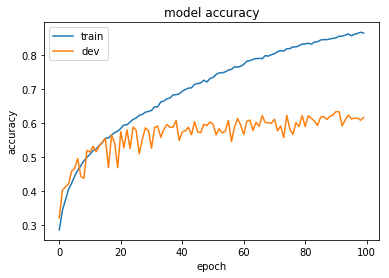

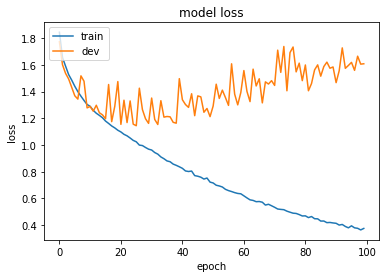

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()